## Trainer with custom dataGenerator
- Dataset: American Sign Languages Dataset
    + link:  https://www.kaggle.com/datasets/grassknoted/asl-alphabet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/MyDrive/WorkSpace/Custom_datagen

/content/drive/MyDrive/WorkSpace/Custom_datagen


## Data_processing

In [1]:
# download zip dataset
import gdown
import warnings
warnings.filterwarnings("ignore", module="matplotlib")
#https://drive.google.com/file/d/1PqmmJ8hkGcH6DqJFlJOXIHlK-RmODqvG/view?usp=sharing
!gdown --no-cookies "1PqmmJ8hkGcH6DqJFlJOXIHlK-RmODqvG"

Downloading...
From: https://drive.google.com/uc?id=1PqmmJ8hkGcH6DqJFlJOXIHlK-RmODqvG
To: /content/archive.zip
100% 1.10G/1.10G [00:11<00:00, 98.6MB/s]


In [4]:
#Import the libraries
import zipfile
import os
import shutil
import numpy as np
from imutils import paths

zip_ref = zipfile.ZipFile("/content/archive.zip", 'r') #Opens the zip file in read mode
zip_ref.extractall('/dataset') 
zip_ref.close()

In [3]:
#Import the libraries for training
import tensorflow as tf 
import cv2   
import random
import matplotlib.pyplot as plt  
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import Sequence, to_categorical
from keras.applications import imagenet_utils
import seaborn as sns

from dataGenerator import DataGenerator
from model import MyModel
from processing import Folder_split, get_images_labels
from confusion_matrix import Confusion_Matrix

In [7]:
#new path
path_train = "/dataset/asl_alphabet_train/asl_alphabet_train/"
path_test = "/dataset/asl_alphabet_test/asl_alphabet_test/"

### Split Folder train val and test

In [8]:
root_folder = "/dataset/asl_alphabet_train/asl_alphabet_train"
image_paths = list(paths.list_images(root_folder))

list_labels =  os.listdir(root_folder)
print(len(image_paths))
print((list_labels))

87000
['D', 'nothing', 'V', 'I', 'W', 'X', 'P', 'O', 'S', 'B', 'H', 'F', 'M', 'J', 'C', 'space', 'N', 'A', 'K', 'Q', 'T', 'G', 'U', 'Z', 'L', 'R', 'Y', 'del', 'E']


In [9]:
# Create train, val, test folders
train_paths, val_paths , test_paths = Folder_split(root_folder, list_labels)

### Get Images and Labels




In [11]:
#lấy đường dẫn hình ảnh cho các train val và test
train_images_path, train_labels_name = get_images_labels(train_paths)
val_images_path, val_labels_name = get_images_labels(val_paths)
test_images_path, test_labels_name = get_images_labels(test_paths)

In [12]:
print("Number Image of train:", len(train_images_path))
print("---"*3)
print("Number Image of vaild", len(val_images_path))
print("---"*3)
print("Number Image of test", len(test_images_path))

Number Image of train: 60900
---------
Number Image of vaild 13050
---------
Number Image of test 13050


In [13]:
# labels encoder
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_labels = lb.fit_transform(train_labels_name)
val_labels = lb.transform(val_labels_name)
test_labels = lb.transform(test_labels_name)

### Plot some images

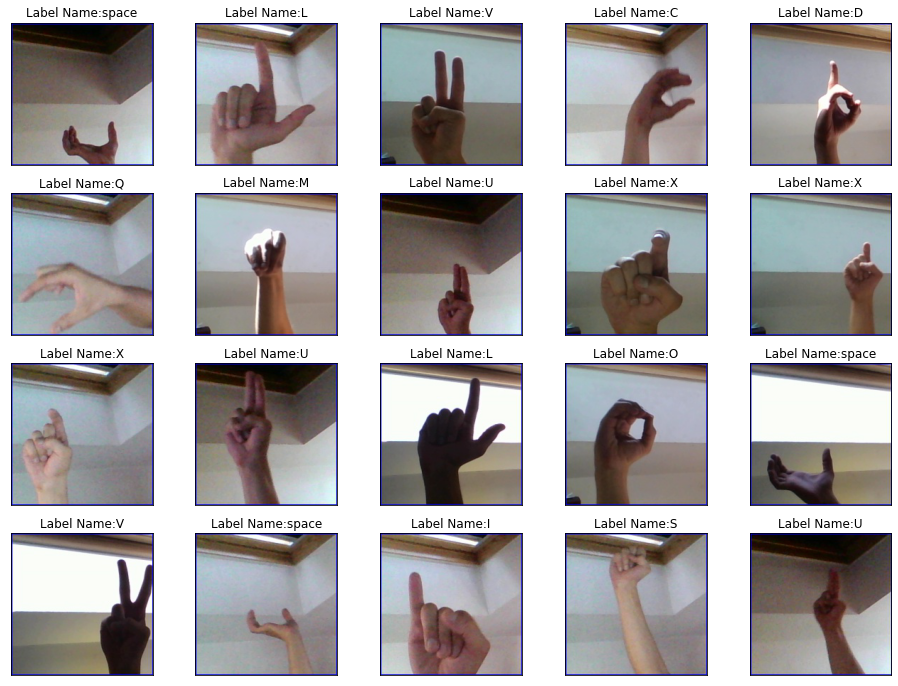

In [14]:
plt.figure(figsize=(16, 12))
for i in range(20):
    idx = np.random.randint(0, len(train_images_path) - 1)
    plt.subplot(4, 5, i+1)
    img = train_images_path[idx]
    plt.imshow(plt.imread(img))
    plt.title('Label Name:{}'.format(train_labels_name[idx], size=15, color="black"))
    plt.xticks([])
    plt.yticks([])

In [15]:
params = {'batch_size': 64,
          'dim': (128,128),
          'n_channels' : 3,
          'n_classes': 29,
          'shuffle': True}

# Load datasets
train_generator = DataGenerator(train_images_path, train_labels, **params)
val_generator = DataGenerator(val_images_path, val_labels, **params)

##Model-CNN

In [16]:
model = MyModel(filter = 64, kernel = (3,3), node = 64, outputs=29)
model.build(input_shape=(None,128,128,3))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 62, 62, 64)        38720     
                                                                 
 sequential_1 (Sequential)   (None, 29, 29, 128)       221440    
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 256)       885248    
                                                                 
 sequential_3 (Sequential)   (None, 7, 7, 512)         3539968   
                                                                 
 sequential_4 (Sequential)   (None, 29)                102883357 
                                                                 
Total params: 107,568,733
Trainable params: 107,568,733
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss ="categorical_crossentropy", optimizer ="adam", metrics = ["accuracy"])
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

checkpoint_filepath = "/content/BestWeights.hdf5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose= 1,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True, save_weights_only = True)


In [ ]:
H = model.fit(train_generator, validation_data = val_generator, epochs= 50, callbacks= [EarlyStopping, model_checkpoint])

Epoch 1/50
951/951 [==============================] - ETA: 0s - loss: 2.0485 - accuracy: 0.5042
Epoch 1: val_accuracy improved from -inf to 0.93511, saving model to /content/drive/MyDrive/Machine_Learning_PM18/BestWeights.hdf5
951/951 [==============================] - 132s 138ms/step - loss: 2.0485 - accuracy: 0.5042 - val_loss: 0.2129 - val_accuracy: 0.9351
Epoch 2/50
951/951 [==============================] - ETA: 0s - loss: 0.1083 - accuracy: 0.9659
Epoch 2: val_accuracy improved from 0.93511 to 0.96321, saving model to /content/drive/MyDrive/Machine_Learning_PM18/BestWeights.hdf5
951/951 [==============================] - 131s 137ms/step - loss: 0.1083 - accuracy: 0.9659 - val_loss: 0.1250 - val_accuracy: 0.9632
Epoch 3/50
951/951 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9848
Epoch 3: val_accuracy improved from 0.96321 to 0.97675, saving model to /content/drive/MyDrive/Machine_Learning_PM18/BestWeights.hdf5
951/951 [==============================] - 

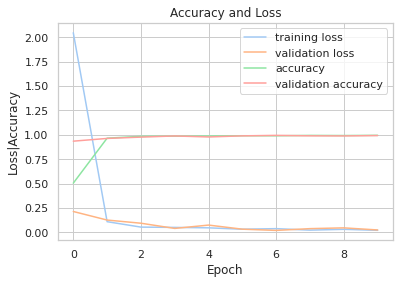

In [ ]:
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [ ]:
import math
params = {'batch_size': 1,
          'dim': (128,128),
          'n_channels' : 3,
          'n_classes': 29,
          'shuffle': None}

# lấy giá trị y_true để predict

test_generator = DataGenerator(test_images_path, val_labels, **params)
number_of_examples = len(test_generator)

test_labels = []
images = []   # images to test
for i in range(0,int(number_of_examples)):
    test_labels.extend(np.array(test_generator[i][1]))
    images.extend(np.array(test_generator[i][0]))

print(test_labels[1])
len(test_labels)



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0.]


13050

In [ ]:
model.evaluate(test_generator)

13050/13050 [==============================] - 90s 7ms/step - loss: 0.0123 - accuracy: 0.9959


[0.012306788936257362, 0.9959387183189392]

+ precision = 0.996
+ recall = 0.996
+ f1_score = 0.996


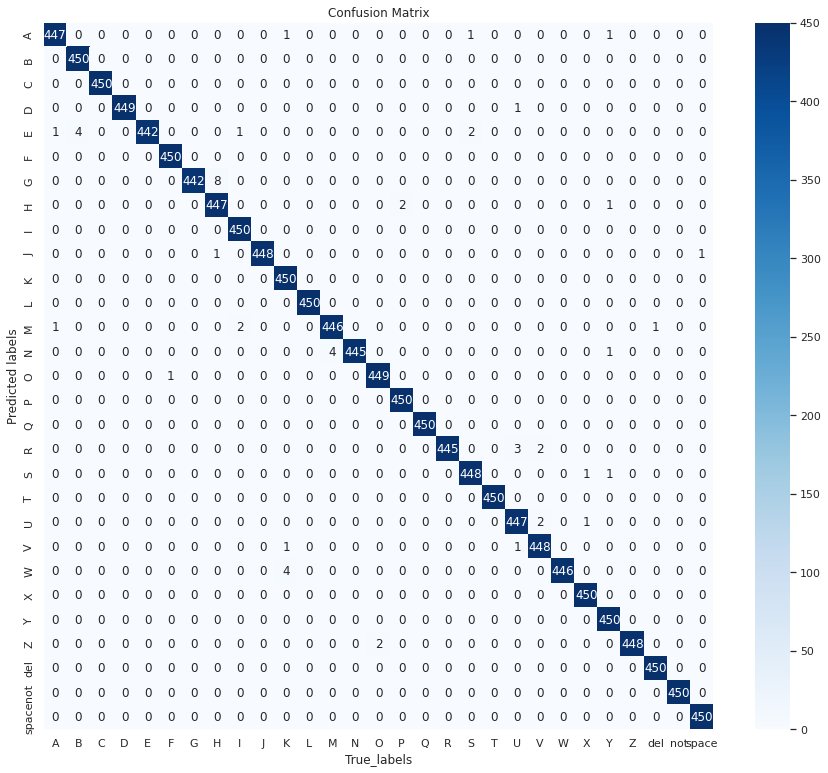

In [ ]:
Confusion_Matrix(model, test_generator, test_labels, classes )

In [ ]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

wrong_images, T_labels, F_labels = [], [] ,[]
for i, test_image in enumerate(images):
    if y_pred[i] == y_true[i]:
      pass
    else:
      wrong_images.append(test_image)
      T_labels.append(y_true[i])
      F_labels.append(y_pred[i])

In [ ]:
print("--"*100)
print("Wrong images: ", len(wrong_images))

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Số ảnh dự đoán sai trong tập test là:  53


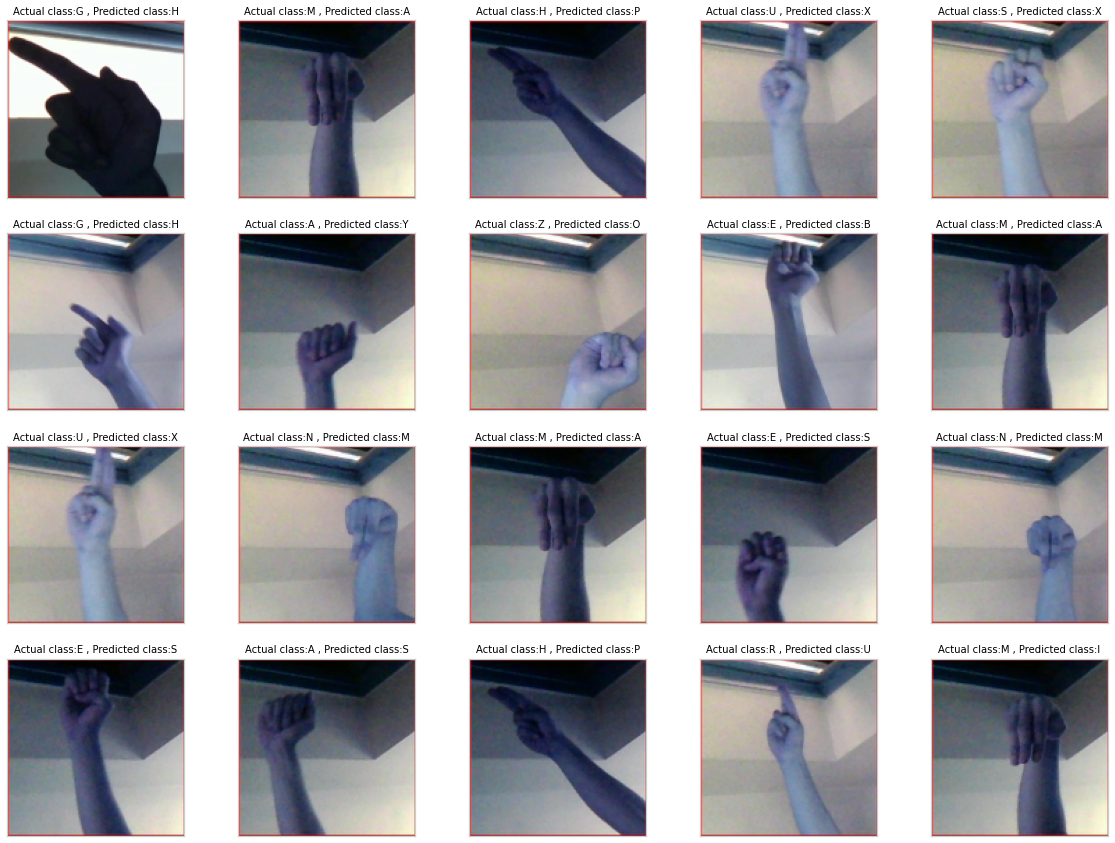

In [ ]:
classes = os.listdir(path_train)
classes.sort()

plt.figure(figsize=(20, 15))
for i in range(20):
    idx = np.random.randint(0, len(wrong_images) - 1)
    plt.subplot(4, 5, i+1)
    img = wrong_images[idx]
    plt.imshow((img).astype("uint8"))

    True_labels =  classes[T_labels[idx]]
    False_labels = classes[F_labels[idx]]

    plt.title('Actual class:{} , Predicted class:{}'.format(True_labels, False_labels), size=10, color="black") 
    plt.xticks([])
    plt.yticks([])

## Test on private Test

Actual class: B 
 Predicted class: B


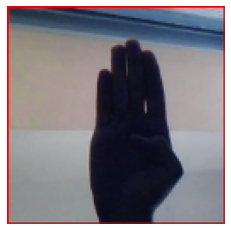

Actual class: space 
 Predicted class: space


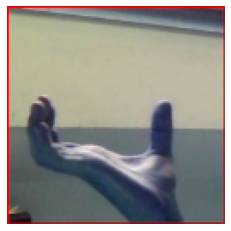

Actual class: G 
 Predicted class: G


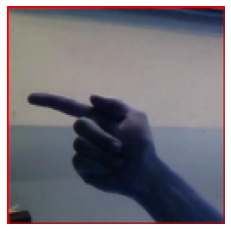

Actual class: S 
 Predicted class: S


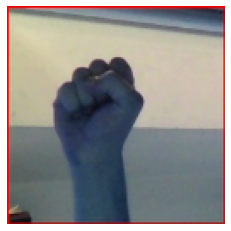

Actual class: A 
 Predicted class: A


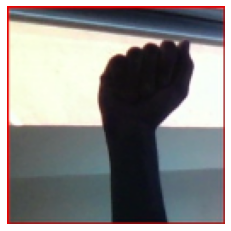

Actual class: Z 
 Predicted class: Z


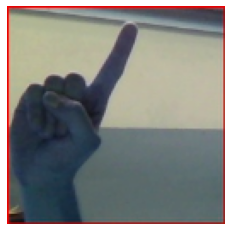

Actual class: F 
 Predicted class: F


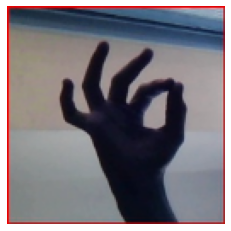

Actual class: Y 
 Predicted class: Y


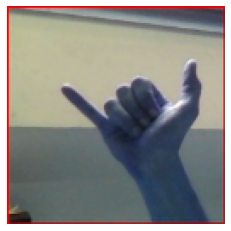

Actual class: E 
 Predicted class: E


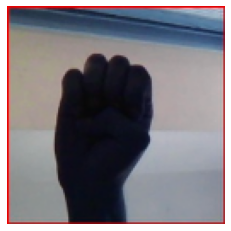

Actual class: U 
 Predicted class: U


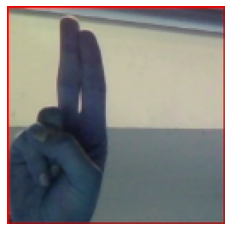

Actual class: K 
 Predicted class: K


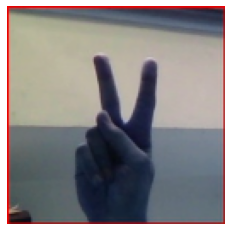

Actual class: C 
 Predicted class: C


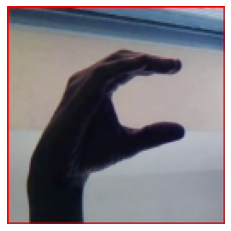

Actual class: N 
 Predicted class: N


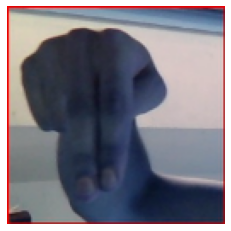

Actual class: X 
 Predicted class: X


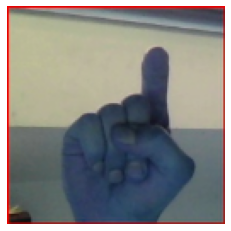

Actual class: J 
 Predicted class: J


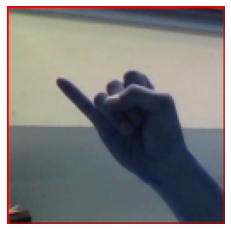

Actual class: I 
 Predicted class: I


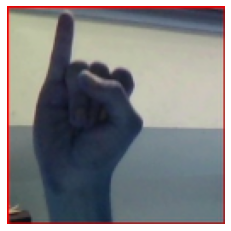

Actual class: H 
 Predicted class: H


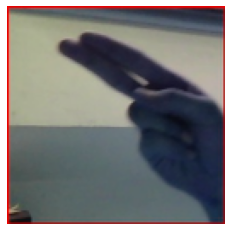

Actual class: W 
 Predicted class: W


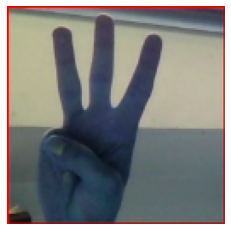

Actual class: V 
 Predicted class: V


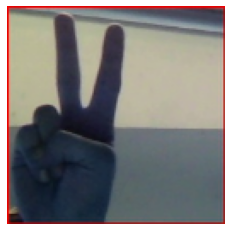

Actual class: L 
 Predicted class: L


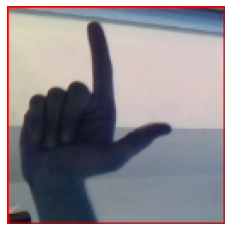

Actual class: D 
 Predicted class: D


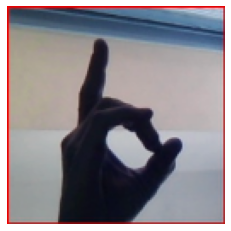

Actual class: P 
 Predicted class: P


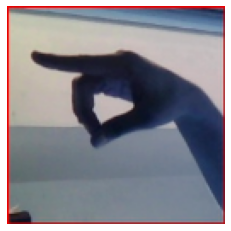

Actual class: O 
 Predicted class: O


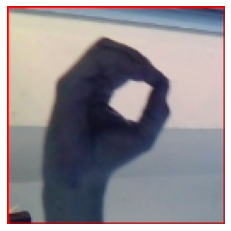

Actual class: nothing 
 Predicted class: nothing


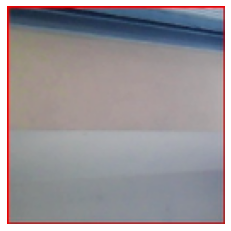

Actual class: R 
 Predicted class: R


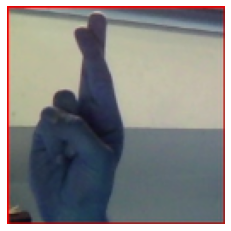

Actual class: T 
 Predicted class: T


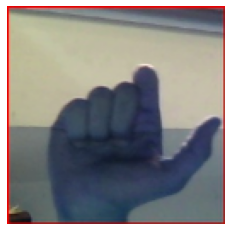

Actual class: Q 
 Predicted class: Q


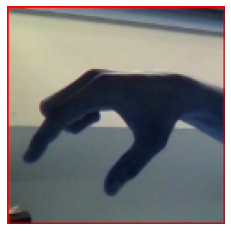

Actual class: M 
 Predicted class: M


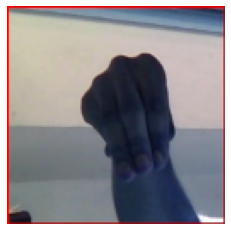

In [ ]:

classes = os.listdir(path_train)
classes.sort()

for i, test_image in enumerate(os.listdir(path_test)):
    image_location = path_test + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (128, 128))
    plt.figure()
    plt.axis('Off')
    plt.imshow(img)
    # img = np.array(img) / 255.
    img = img.reshape((1, 128, 128, 3))
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} \n Predicted class: {}'.format(actual, predicted))
    plt.show()